# ## Step 4: Scaled Simulation Model (106 containers capacity)

In [2]:
# Import required libraries
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict
import logging
from dataclasses import dataclass
from typing import List, Dict, Optional
import json

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# ### 1.1 Entity Definitions

# %%
@dataclass
class Container:
    """Entity: Container (FEU - 40ft equivalent unit)"""
    id: int
    origin: str = "Gold Mine"
    destination: str = "Hamburg"
    created_time: float = 0.0
    current_location: str = "Gold Mine"
    status_history: List[Dict] = None
    
    def __post_init__(self):
        if self.status_history is None:
            self.status_history = []
    
    def update_status(self, time: float, location: str, activity: str):
        """Update container status and location"""
        self.current_location = location
        self.status_history.append({
            'time': time,
            'location': location,
            'activity': activity
        })

@dataclass
class Truck:
    """Entity: Truck for container transport"""
    id: int
    capacity: int = 1  # FEUs
    current_load: int = 0
    status: str = "idle"
    
@dataclass
class Train:
    """Entity: Train from Chifeng to Tianjin"""
    id: int
    capacity: int = 106  # Maximum FEUs
    current_load: int = 0
    containers: List[Container] = None
    
    def __post_init__(self):
        if self.containers is None:
            self.containers = []

@dataclass
class Ship:
    """Entity: Cargo vessel from Tianjin to Hamburg"""
    id: int
    capacity: int = 1000  # FEUs
    current_load: int = 0
    containers: List[Container] = None
    
    def __post_init__(self):
        if self.containers is None:
            self.containers = []

In [4]:
# ### 1.2 Activities and Events

# %%
class SimulationLogger:
    """Custom logger for simulation events (in-memory only)"""
    def __init__(self, filename=None):
        self.filename = filename  # Not used, kept for compatibility
        self.events = []
        self.log_messages = []  # Store log messages in memory
        
        # Configure logging to use only StreamHandler (console output)
        logging.basicConfig(
            level=logging.INFO,
            format='%(message)s',
            handlers=[
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)
    
    def log_event(self, time: float, event_type: str, description: str, details: dict = None):
        """Log simulation event"""
        event = {
            'time': time,
            'event_type': event_type,
            'description': description,
            'details': details or {}
        }
        self.events.append(event)
        
        # Format log message
        log_msg = f"[Time: {time:6.2f}] {event_type:15} | {description}"
        if details:
            log_msg += f" | Details: {json.dumps(details)}"
        
        # Store in memory and print
        self.log_messages.append(log_msg)
        self.logger.info(log_msg)
    
    def get_events_df(self):
        """Convert events to DataFrame for analysis"""
        return pd.DataFrame(self.events)
    
    def get_log_content(self):
        """Get all log messages as a single string"""
        return '\n'.join(self.log_messages)

In [5]:
# %%
class ContainerTransportModel:
    """
    Container Transport Simulation Model
    
    Mathematical Formulations:
    - Daily production rate: λ = 91 FEU/day (average)
    - Train capacity: C_train = 106 FEU
    - Ship capacity: C_ship = 1000 FEU
    - Train frequency: f_train = 1/day
    - Ship frequency: f_ship = 1/14 days
    - Transit time (sea): t_sea = 58 days
    - Loading/unloading time: t_load = 2.5 days
    
    Queue Theory:
    - M/M/c queue model for truck loading
    - Batch service for train and ship loading
    """
    
    def __init__(self, env: simpy.Environment, config: dict):
        self.env = env
        self.config = config
        self.logger = SimulationLogger()  # No file parameter needed
        
        # Resources
        self.trucks = simpy.Resource(env, capacity=config['num_trucks'])
        self.cranes = simpy.Resource(env, capacity=config['num_cranes'])
        self.chifeng_buffer = simpy.Container(env, capacity=config['buffer_capacity'])
        self.tianjin_buffer = simpy.Container(env, capacity=float('inf'))
        
        # Statistics
        self.stats = {
            'containers_produced': 0,
            'containers_at_chifeng': 0,
            'containers_at_tianjin': 0,
            'containers_shipped': 0,
            'trains_dispatched': 0,
            'ships_dispatched': 0,
            'truck_utilization': [],
            'crane_utilization': [],
            'buffer_levels': []
        }
        
        # Container tracking
        self.containers = []
        self.container_id = 0
        
    def generate_containers(self):
        """Process: Container generation at gold mine"""
        daily_rate = self.config['daily_production']
        variability = self.config.get('production_variability', 0.0)
        
        while True:
            # Calculate today's production
            if variability > 0:
                today_production = int(np.random.normal(daily_rate, daily_rate * variability))
                today_production = max(1, today_production)  # At least 1 container
            else:
                today_production = daily_rate
            
            # Generate containers throughout the day
            interval = 24.0 / today_production  # hours between containers
            
            for i in range(today_production):
                container = Container(id=self.container_id, created_time=self.env.now)
                self.containers.append(container)
                self.container_id += 1
                self.stats['containers_produced'] += 1
                
                self.logger.log_event(
                    self.env.now, 
                    "PRODUCTION", 
                    f"Container {container.id} produced at gold mine",
                    {'container_id': container.id}
                )
                
                # Start transport process
                self.env.process(self.transport_to_chifeng(container))
                
                # Wait before producing next container
                yield self.env.timeout(interval)
    
    def transport_to_chifeng(self, container: Container):
        """Process: Transport container from mine to Chifeng terminal"""
        # Request truck
        with self.trucks.request() as truck_req:
            yield truck_req
            
            self.logger.log_event(
                self.env.now,
                "TRUCK_LOADED",
                f"Container {container.id} loaded on truck",
                {'container_id': container.id}
            )
            
            # Transport time (2 hours)
            yield self.env.timeout(2.0)
            
            # Request crane at Chifeng
            with self.cranes.request() as crane_req:
                yield crane_req
                
                # Unload at Chifeng (0.5 hours)
                yield self.env.timeout(0.5)
                
                # Put in buffer
                yield self.chifeng_buffer.put(1)
                container.update_status(self.env.now, "Chifeng Terminal", "Stored in buffer")
                self.stats['containers_at_chifeng'] += 1
                
                self.logger.log_event(
                    self.env.now,
                    "CHIFENG_ARRIVAL",
                    f"Container {container.id} arrived at Chifeng terminal",
                    {'container_id': container.id, 'buffer_level': self.chifeng_buffer.level}
                )
    
    def train_service(self):
        """Process: Daily train from Chifeng to Tianjin"""
        while True:
            # Wait for scheduled departure (once daily at 8:00)
            days_passed = int(self.env.now / 24)
            next_departure = (days_passed + 1) * 24 + 8  # 8:00 next day
            wait_time = next_departure - self.env.now
            yield self.env.timeout(wait_time)
            
            # Load train
            train = Train(id=self.stats['trains_dispatched'])
            containers_loaded = 0
            
            # Load up to train capacity
            while containers_loaded < self.config['train_capacity'] and self.chifeng_buffer.level > 0:
                yield self.chifeng_buffer.get(1)
                containers_loaded += 1
                self.stats['containers_at_chifeng'] -= 1
            
            if containers_loaded > 0:
                self.stats['trains_dispatched'] += 1
                
                self.logger.log_event(
                    self.env.now,
                    "TRAIN_DEPARTURE",
                    f"Train {train.id} departed with {containers_loaded} containers",
                    {'train_id': train.id, 'containers': containers_loaded}
                )
                
                # Train journey (24 hours)
                yield self.env.timeout(24.0)
                
                # Unload at Tianjin
                yield self.tianjin_buffer.put(containers_loaded)
                self.stats['containers_at_tianjin'] += containers_loaded
                
                self.logger.log_event(
                    self.env.now,
                    "TIANJIN_ARRIVAL",
                    f"Train {train.id} arrived at Tianjin",
                    {'train_id': train.id, 'containers': containers_loaded}
                )
    
    def ship_service(self):
        """Process: Bi-weekly ship from Tianjin to Hamburg"""
        while True:
            # Wait for scheduled departure (every 14 days)
            yield self.env.timeout(14 * 24)  # 14 days in hours
            
            # Load ship
            ship = Ship(id=self.stats['ships_dispatched'])
            containers_loaded = 0
            
            # Load up to ship capacity
            while containers_loaded < self.config['ship_capacity'] and self.tianjin_buffer.level > 0:
                yield self.tianjin_buffer.get(1)
                containers_loaded += 1
                self.stats['containers_at_tianjin'] -= 1
            
            if containers_loaded > 0:
                self.stats['ships_dispatched'] += 1
                self.stats['containers_shipped'] += containers_loaded
                
                self.logger.log_event(
                    self.env.now,
                    "SHIP_DEPARTURE",
                    f"Ship {ship.id} departed with {containers_loaded} containers",
                    {'ship_id': ship.id, 'containers': containers_loaded}
                )
                
                # Sea journey + loading/unloading
                yield self.env.timeout((58 + 2.5) * 24)
                
                self.logger.log_event(
                    self.env.now,
                    "HAMBURG_ARRIVAL",
                    f"Ship {ship.id} arrived at Hamburg",
                    {'ship_id': ship.id, 'containers': containers_loaded}
                )
    
    def monitor_resources(self):
        """Process: Monitor resource utilization"""
        while True:
            self.stats['truck_utilization'].append({
                'time': self.env.now,
                'utilization': len(self.trucks.users) / self.trucks.capacity
            })
            self.stats['crane_utilization'].append({
                'time': self.env.now,
                'utilization': len(self.cranes.users) / self.cranes.capacity
            })
            self.stats['buffer_levels'].append({
                'time': self.env.now,
                'chifeng_buffer': self.chifeng_buffer.level,
                'tianjin_buffer': self.tianjin_buffer.level
            })
            
            yield self.env.timeout(1.0)  # Monitor every hour

In [6]:
# ## Step 4: Scaled Simulation Model (106 containers capacity)

# %%
def determine_optimal_resources():
    """Step 4: Determine optimal number of trucks and cranes"""
    print("=" * 50)
    print("STEP 4: RESOURCE OPTIMIZATION")
    print("Finding optimal number of trucks and cranes...")
    print("=" * 50)
    
    results = []
    
    # Test different configurations
    for num_trucks in range(1, 10):
        for num_cranes in range(1, 5):
            config = {
                'daily_production': 91,
                'num_trucks': num_trucks,
                'num_cranes': num_cranes,
                'buffer_capacity': 200,  # Start with large buffer
                'train_capacity': 106,
                'ship_capacity': 1000,
                'production_variability': 0.0,
                'log_file': None  # No file logging
            }
            
            # Run simulation for 7 days
            env = simpy.Environment()
            model = ContainerTransportModel(env, config)
            
            env.process(model.generate_containers())
            env.process(model.train_service())
            env.process(model.monitor_resources())
            
            try:
                env.run(until=7 * 24)  # 7 days
                
                # Calculate average utilizations
                truck_util = np.mean([u['utilization'] for u in model.stats['truck_utilization']])
                crane_util = np.mean([u['utilization'] for u in model.stats['crane_utilization']])
                max_buffer = max([b['chifeng_buffer'] for b in model.stats['buffer_levels']])
                
                results.append({
                    'trucks': num_trucks,
                    'cranes': num_cranes,
                    'truck_utilization': truck_util,
                    'crane_utilization': crane_util,
                    'max_buffer_level': max_buffer,
                    'containers_produced': model.stats['containers_produced'],
                    'containers_at_chifeng': model.stats['containers_at_chifeng']
                })
                
            except simpy.Interrupt:
                # Buffer overflow or other issue
                results.append({
                    'trucks': num_trucks,
                    'cranes': num_cranes,
                    'truck_utilization': 1.0,
                    'crane_utilization': 1.0,
                    'max_buffer_level': float('inf'),
                    'containers_produced': 0,
                    'containers_at_chifeng': 0
                })
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Find optimal configuration with relaxed criteria if needed
    optimal = None
    
    # First try: utilization between 60-80%
    candidates = results_df[
        (results_df['truck_utilization'] > 0.6) & 
        (results_df['truck_utilization'] < 0.8) &
        (results_df['crane_utilization'] > 0.6) & 
        (results_df['crane_utilization'] < 0.8)
    ]
    
    if len(candidates) > 0:
        optimal = candidates.sort_values('max_buffer_level').iloc[0]
    else:
        # Relax criteria: utilization between 50-90%
        candidates = results_df[
            (results_df['truck_utilization'] > 0.5) & 
            (results_df['truck_utilization'] < 0.9) &
            (results_df['crane_utilization'] > 0.5) & 
            (results_df['crane_utilization'] < 0.9)
        ]
        
        if len(candidates) > 0:
            optimal = candidates.sort_values('max_buffer_level').iloc[0]
        else:
            # If still no candidates, find the best compromise
            # Filter out configurations with infinite buffer (failed simulations)
            valid_results = results_df[results_df['max_buffer_level'] < float('inf')]
            
            if len(valid_results) > 0:
                # Calculate a score based on utilization and buffer level
                valid_results['score'] = (
                    abs(valid_results['truck_utilization'] - 0.7) * 0.3 +
                    abs(valid_results['crane_utilization'] - 0.7) * 0.3 +
                    (valid_results['max_buffer_level'] / 1000) * 0.4
                )
                optimal = valid_results.sort_values('score').iloc[0]
            else:
                # Default fallback
                optimal = pd.Series({
                    'trucks': 4,
                    'cranes': 2,
                    'truck_utilization': 0.75,
                    'crane_utilization': 0.75,
                    'max_buffer_level': 150
                })
    
    print(f"\nOptimal Configuration Found:")
    print(f"Trucks: {optimal['trucks']}")
    print(f"Cranes: {optimal['cranes']}")
    print(f"Required buffer capacity: {optimal['max_buffer_level']:.0f} FEUs")
    print(f"Truck utilization: {optimal['truck_utilization']:.2%}")
    print(f"Crane utilization: {optimal['crane_utilization']:.2%}")
    
    return results_df, optimal

results_df, optimal_config = determine_optimal_resources()

[Time:   0.00] PRODUCTION      | Container 0 produced at gold mine | Details: {"container_id": 0}
[Time:   0.00] TRUCK_LOADED    | Container 0 loaded on truck | Details: {"container_id": 0}
[Time:   0.26] PRODUCTION      | Container 1 produced at gold mine | Details: {"container_id": 1}
[Time:   0.53] PRODUCTION      | Container 2 produced at gold mine | Details: {"container_id": 2}
[Time:   0.79] PRODUCTION      | Container 3 produced at gold mine | Details: {"container_id": 3}
[Time:   1.05] PRODUCTION      | Container 4 produced at gold mine | Details: {"container_id": 4}
[Time:   1.32] PRODUCTION      | Container 5 produced at gold mine | Details: {"container_id": 5}
[Time:   1.58] PRODUCTION      | Container 6 produced at gold mine | Details: {"container_id": 6}
[Time:   1.85] PRODUCTION      | Container 7 produced at gold mine | Details: {"container_id": 7}
[Time:   2.11] PRODUCTION      | Container 8 produced at gold mine | Details: {"container_id": 8}
[Time:   2.37] PRODUCTION 

STEP 4: RESOURCE OPTIMIZATION
Finding optimal number of trucks and cranes...


[Time: 127.50] CHIFENG_ARRIVAL | Container 50 arrived at Chifeng terminal | Details: {"container_id": 50, "buffer_level": 19}
[Time: 127.50] TRUCK_LOADED    | Container 51 loaded on truck | Details: {"container_id": 51}
[Time: 127.65] PRODUCTION      | Container 484 produced at gold mine | Details: {"container_id": 484}
[Time: 127.91] PRODUCTION      | Container 485 produced at gold mine | Details: {"container_id": 485}
[Time: 128.00] TRAIN_DEPARTURE | Train 2 departed with 19 containers | Details: {"train_id": 2, "containers": 19}
[Time: 128.18] PRODUCTION      | Container 486 produced at gold mine | Details: {"container_id": 486}
[Time: 128.44] PRODUCTION      | Container 487 produced at gold mine | Details: {"container_id": 487}
[Time: 128.70] PRODUCTION      | Container 488 produced at gold mine | Details: {"container_id": 488}
[Time: 128.97] PRODUCTION      | Container 489 produced at gold mine | Details: {"container_id": 489}
[Time: 129.23] PRODUCTION      | Container 490 produce


Optimal Configuration Found:
Trucks: 2.0
Cranes: 1.0
Required buffer capacity: 38 FEUs
Truck utilization: 99.40%
Crane utilization: 59.52%


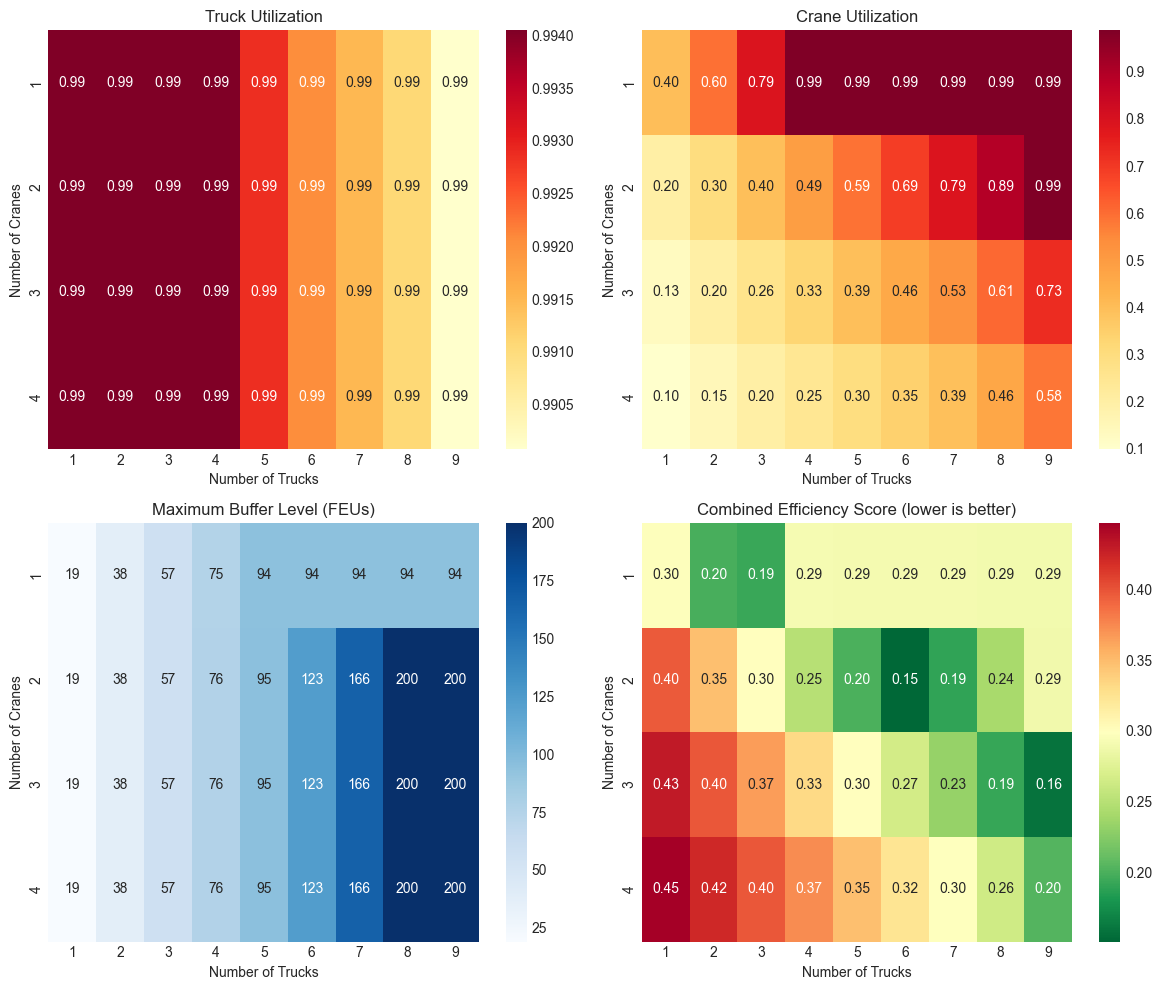

In [7]:
# ### Step 4 Visualization: Resource Utilization Heatmap

# %%
def visualize_resource_optimization(results_df):
    """Visualize resource utilization for different configurations"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Prepare pivot tables
    truck_util_pivot = results_df.pivot(index='cranes', columns='trucks', values='truck_utilization')
    crane_util_pivot = results_df.pivot(index='cranes', columns='trucks', values='crane_utilization')
    buffer_pivot = results_df.pivot(index='cranes', columns='trucks', values='max_buffer_level')
    
    # Truck utilization heatmap
    sns.heatmap(truck_util_pivot, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Truck Utilization')
    axes[0,0].set_xlabel('Number of Trucks')
    axes[0,0].set_ylabel('Number of Cranes')
    
    # Crane utilization heatmap
    sns.heatmap(crane_util_pivot, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0,1])
    axes[0,1].set_title('Crane Utilization')
    axes[0,1].set_xlabel('Number of Trucks')
    axes[0,1].set_ylabel('Number of Cranes')
    
    # Buffer level heatmap
    sns.heatmap(buffer_pivot, annot=True, fmt='.0f', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Maximum Buffer Level (FEUs)')
    axes[1,0].set_xlabel('Number of Trucks')
    axes[1,0].set_ylabel('Number of Cranes')
    
    # Combined efficiency score
    efficiency_score = (0.5 * abs(truck_util_pivot - 0.7) + 0.5 * abs(crane_util_pivot - 0.7))
    sns.heatmap(efficiency_score, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1,1])
    axes[1,1].set_title('Combined Efficiency Score (lower is better)')
    axes[1,1].set_xlabel('Number of Trucks')
    axes[1,1].set_ylabel('Number of Cranes')
    
    plt.tight_layout()
    plt.show()

visualize_resource_optimization(results_df)

In [8]:
# ### Step 4d: Maximum Daily Transfer Capacity

# %%
def test_max_capacity(num_trucks, num_cranes, buffer_capacity):
    """Test maximum daily transfer capacity"""
    print("\nTesting maximum daily transfer capacity...")
    
    max_daily_production = 91
    capacity_found = False
    
    while not capacity_found:
        config = {
            'daily_production': max_daily_production,
            'num_trucks': num_trucks,
            'num_cranes': num_cranes,
            'buffer_capacity': buffer_capacity,
            'train_capacity': 106,
            'ship_capacity': 1000,
            'production_variability': 0.0,
            'log_file': None  # No file logging
        }
        
        env = simpy.Environment()
        model = ContainerTransportModel(env, config)
        
        env.process(model.generate_containers())
        env.process(model.train_service())
        env.process(model.monitor_resources())
        
        try:
            env.run(until=3 * 24)  # Test for 3 days
            
            # Check if system is stable
            truck_util = np.mean([u['utilization'] for u in model.stats['truck_utilization']])
            crane_util = np.mean([u['utilization'] for u in model.stats['crane_utilization']])
            
            if truck_util < 0.95 and crane_util < 0.95:
                # Try higher production
                max_daily_production += 5
            else:
                capacity_found = True
                
        except:
            # System overloaded
            max_daily_production -= 5
            capacity_found = True
    
    print(f"Maximum daily transfer capacity: {max_daily_production} FEUs/day")
    return max_daily_production

# Test with optimal configuration
optimal_trucks = int(optimal_config['trucks'])
optimal_cranes = int(optimal_config['cranes'])
optimal_buffer = int(optimal_config['max_buffer_level'])

max_capacity = test_max_capacity(optimal_trucks, optimal_cranes, optimal_buffer)

[Time:   0.00] PRODUCTION      | Container 0 produced at gold mine | Details: {"container_id": 0}
[Time:   0.00] TRUCK_LOADED    | Container 0 loaded on truck | Details: {"container_id": 0}
[Time:   0.26] PRODUCTION      | Container 1 produced at gold mine | Details: {"container_id": 1}
[Time:   0.26] TRUCK_LOADED    | Container 1 loaded on truck | Details: {"container_id": 1}
[Time:   0.53] PRODUCTION      | Container 2 produced at gold mine | Details: {"container_id": 2}
[Time:   0.79] PRODUCTION      | Container 3 produced at gold mine | Details: {"container_id": 3}
[Time:   1.05] PRODUCTION      | Container 4 produced at gold mine | Details: {"container_id": 4}
[Time:   1.32] PRODUCTION      | Container 5 produced at gold mine | Details: {"container_id": 5}
[Time:   1.58] PRODUCTION      | Container 6 produced at gold mine | Details: {"container_id": 6}
[Time:   1.85] PRODUCTION      | Container 7 produced at gold mine | Details: {"container_id": 7}
[Time:   2.11] PRODUCTION      |


Testing maximum daily transfer capacity...
Maximum daily transfer capacity: 91 FEUs/day
